# Visualize empirical correlation in HCP data

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from diGP.preprocessing import (readHCP,
                                averageb0Volumes,
                                createBrainMaskFromb0Data,
                                replaceNegativeData)
from diGP.dataManipulations import (log_q_squared,
                                    generateCoordinates)

%matplotlib inline

Specify a folder containing preprocessed HCP data.

In [8]:
dataPath = 'C:\\Users\\sesjojen\\Documents\\Data\\HumanConnectomeProject\\mgh_1007\\diff\\preproc'
print(dataPath)

C:\Users\sesjojen\Documents\Data\HumanConnectomeProject\mgh_1007\diff\preproc


Read data from file.

In [9]:
gtab, data, voxelSize = readHCP(dataPath)
print(gtab.info)

B-values shape (552,)
         min 0.000000 
         max 10050.000000 
B-vectors shape (552, 3)
         min -0.998755 
         max 0.998348 
None


This data has some negative values, which is unrealistic. This is taken care of by the function replaceNegativeData().

In [4]:
data = replaceNegativeData(data, gtab)

Convert diffusion encoding to q-space features usable in prediction.

<function matplotlib.pyplot.show>

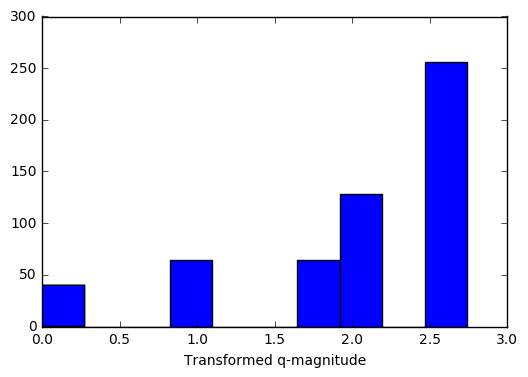

In [12]:
def qMagnitudeTransform(q):
    return log_q_squared(q, c=1.)

qvecs = gtab.bvecs
qvals = gtab.qvals[:, np.newaxis]
qvalsTransformed = qMagnitudeTransform(qvals)

qFeatures = np.column_stack((qvalsTransformed, qvecs))

plt.hist(qvalsTransformed)
plt.xlabel('Transformed q-magnitude')
plt.show

Compute the spatial coordinates corresponding to each measurement.

In [14]:
spatialDimensions = data.shape[0:3]
coordinates = generateCoordinates(spatialDimensions, voxelSize)
coordinates.shape

(1881600, 3)

Compute a mask containing the brain. For this we first need to create an average b0-img, which is done by averaging all b0 images. Then, we pass this to createBrainMaskFromb0Data() which uses Dipy's median_otsu() function.


In [16]:
b0 = averageb0Volumes(data, gtab)

mask = createBrainMaskFromb0Data(b0)

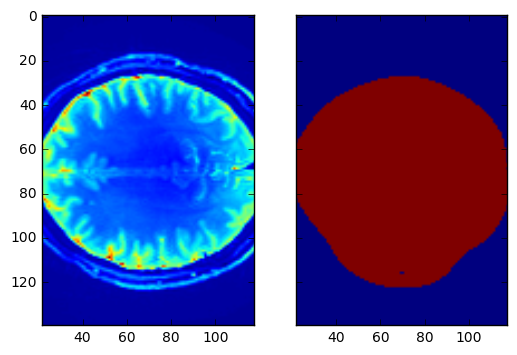

In [17]:
zSlice = 60
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(b0[:, :, zSlice])
ax2.imshow(mask[:, :, zSlice])


Get the (x, y, z)-indices of voxels belonging to the mask using numpy.nonzero().

In [18]:
maskIdx = np.nonzero(mask)
S = data[maskIdx[0], maskIdx[1], maskIdx[2], :]

Normalize by the b0-image, taking advantage of Numpy's broadcasting.

In [19]:
S = S/b0[maskIdx[0], maskIdx[1], maskIdx[2], np.newaxis]
maxSignal = 1.5
percentExceedingMaxSignal = 100*np.sum(S>maxSignal)/np.prod(S.shape)
print('Replacing the top {} % values with {}.'.format(percentExceedingMaxSignal, maxSignal))
S[S > maxSignal] = maxSignal

Replacing the top 0.1228921280458935 % values with 1.5.


Sort columns so that bvals are monotonically increasing: 0, 1000, 3000, 5000, 10000. Adjust other data accordingly.

In [20]:
bvalsIdxIncreasing = np.argsort(gtab.bvals)
bvals = gtab.bvals[bvalsIdxIncreasing]
bvecs = gtab.bvecs[bvalsIdxIncreasing, :]
S = S[:, bvalsIdxIncreasing]
qFeatures = qFeatures[bvalsIdxIncreasing, :]

Some measurements have b = 9950 or b = 10050. We want to treat them as part of the b=10000 shell.

In [21]:
bvals[np.logical_and(bvals >= 9950., bvals <= 10050.)] = 10000. 
shells = np.unique(bvals)
print(shells)
shellIdx = [bvals == b for b in shells]

[     0.   1000.   3000.   5000.  10000.]


From the perspective of the qFeatures, each row in S is an observation and each column is a feature. Assuming that the rows are independent (enough) we can thus estimate the mean  signal as a function of qFeatures by averaging over the rows. The hypothesis is that the mean only depends on the q-magnitude, so we expect the empirical mean to be stepwise constant. 

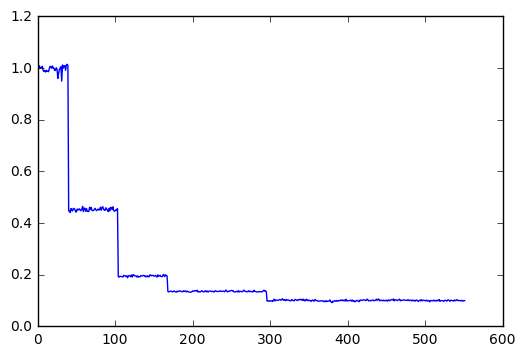

In [22]:
mu = np.mean(S, axis=0)
plt.plot(mu)

The hypothesis seems to hold nicely. Now we can compute the empirical covariance.

In [100]:
def computeEmpiricalCovariance(A):
    mu = np.mean(A, axis=0)
    Acentered = A - mu[np.newaxis, :]
    N = A.shape[0]
    empiricalCovariance = 1/(N-1)*np.dot(Acentered.T, Acentered)
    return empiricalCovariance


def removeShellMeans(A, shellIdx):
    A2 = np.zeros_like(A)
    for ind in shellIdx:
        shellMeans = np.mean(A[:, ind], axis=1)
        A2[:, ind] = A[:, ind] - shellMeans[:, np.newaxis]
    return A2

#R = np.corrcoef(removeShellMeans(S, shellIdx).T)
R = np.corrcoef(S.T)

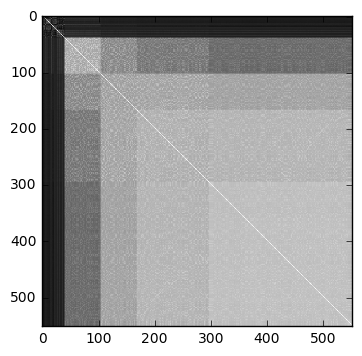

In [101]:
plt.imshow(R, cmap='gray')

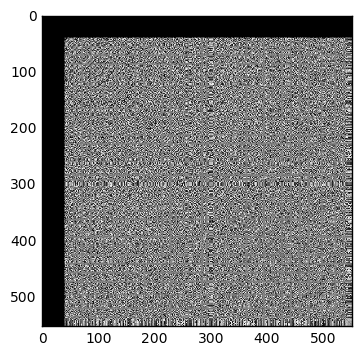

In [111]:
bvecsOuterProd = bvecs.dot(bvecs.T)
bvecsOuterProd[bvecsOuterProd > 1.] = 1.
bvecsOuterProd[bvecsOuterProd < -1.] = -1.
thetaMatrix = np.arccos(bvecsOuterProd)
thetaMatrix[thetaMatrix >= np.pi/2] -= np.pi; 
plt.imshow(thetaMatrix, cmap='gray')

Investigate the covariance as a function of $\theta$ for each shell separately.

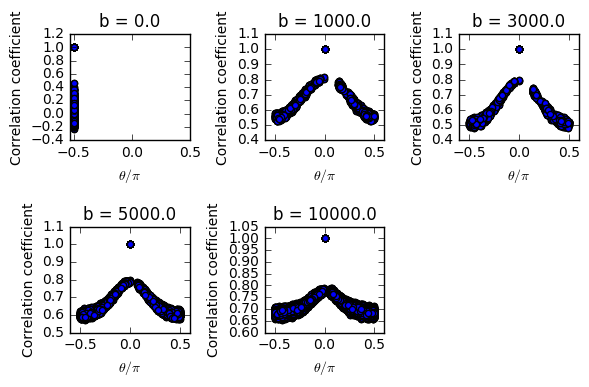

In [115]:
for i in np.arange(len(shells)):
    ind = np.squeeze(np.nonzero(shellIdx[i]))
    subMatrixIdx = np.ix_(ind, ind)
    ax = plt.subplot(2, 3, i+1)
    plt.scatter(thetaMatrix[subMatrixIdx]/np.pi, R[subMatrixIdx])
    plt.xlabel('$\\theta/\pi$')
    plt.ylabel('Correlation coefficient')
    plt.title('b = {}'.format(shells[i]))
    plt.xticks((-0.5, 0, 0.5))
    plt.tight_layout()
